In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
nx = 9
ny = 6
cm = None  # camera_matrix
dcoeff = None # distortion coefficient
PM = None # perspective_matrix
PMinv = None #inverse perspective matrix

In [3]:
PM

In [4]:
def camera_callibrate(img, cm = None, dcoeff = None, nx = nx, ny = ny):
    imgpoints = []
    objpoints = []
    mesh = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objp = np.hstack((mesh, np.zeros(shape = (nx*ny,1))))
    objp = np.array(objp, dtype = np.float32)
    retval, corners = cv2.findChessboardCorners(img,(nx,ny), None)
    if retval == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        retval, cm, dcoeff, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], cm, dcoeff)
    
    return cm,dcoeff

In [5]:
ilist = os.listdir("./camera_cal/")

In [6]:
for im_name in ilist:
    filename = "./camera_cal/" + im_name
    img = mpimg.imread(filename)
    cm, dcoeff = camera_callibrate(img, cm, dcoeff)

In [7]:
def undistort(img, cm, dcoeff, fig_show = False):
    dest = cv2.undistort(img, cm, dcoeff)
    if fig_show == True:
        plt.figure()
        plt.imshow(dest)
    return dest

In [8]:
# for im_name in inp_list:
#     filename = "./test_images/" + im_name
#     print(im_name)
#     img = mpimg.imread(filename)
#     plt.figure()
#     plt.imshow(img)

In [9]:
# for im_name in inp_list:
#     filename = "./test_images/" + im_name
#     print(im_name)
#     img = mpimg.imread(filename)
#     undist = undistort(img, cm, dcoeff)
#     warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
#     plt.figure()
#     plt.imshow(warped)

In [10]:
# # Code to display in interactive window - cv2.waitKey() and cv2.destroyAllWindows() are necessary 
# # to keep the window alive.... To close image window - press Enter on the image

# img = cv2.imread('./test_images/straight_lines2.jpg')
# undist = undistort(img, cm, dcoeff)
# warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
# cv2.imshow('ImageWindow', warped)
# cv2.waitKey()
# cv2.destroyAllWindows()

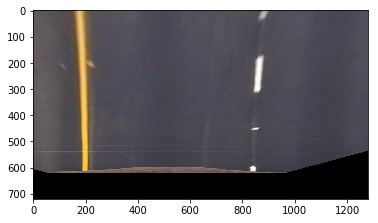

In [12]:
# Perspective matrix creation
img = mpimg.imread("./test_images/straight_lines1.jpg")
undist = undistort(img, cm, dcoeff)
src = np.array([[484,528],[805,528],[1038,676],[265,676]],dtype=np.float32)
dst = np.array([[200,400],[840,400],[840,600],[200,600]],dtype=np.float32)

# src = np.float32([[490, 482],[810, 482], [1250, 720],[40, 720]],dtype=np.float32)
# dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]],dtype=np.float32)

PM = cv2.getPerspectiveTransform(src, dst)
PMinv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(undist, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR) 
plt.imshow(warped)
plt.imsave(fname = "warp_st1.png", arr = warped)

In [13]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255), mode = 'mpimg'):
    # Calculate directional gradient
    # Apply threshold    
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    if orient == 'x':
        grad = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    elif orient == 'y':
        grad = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        
    max_grad = np.max(grad)
    grad = np.uint8(255*grad/ max_grad)
    
    grad_binary = np.zeros_like(grad)
    grad_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255), mode = 'mpimg'):
    # Calculate gradient magnitude
    # Apply threshold
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    gradx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    grady = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    grad = np.sqrt(gradx**2 + grady**2)
    
    max_grad = np.max(grad)
    grad = np.uint8(255*grad/ max_grad)
    
    grad_binary = np.zeros_like(grad)
    grad_binary[(grad >= mag_thresh[0]) & (grad <= mag_thresh[1])] = 1
    return grad_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2), mode = 'mpimg'):
    # Calculate gradient direction
    # Apply threshold
    if mode == 'mpimg':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    gradx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    grady = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    
    dir_grad = np.arctan2(grady, gradx)
    
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    
    return binary_output

def s_threshold(img, s_thres=(0,255), mode = 'mpimg'):
    
    if mode == 'mpimg':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif mode == 'cv2':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    s = hls[:,:,2]
    binary_output = np.zeros_like(gray)
    binary_output[(s>=s_thres[0]) & (s<=s_thres[1])] = 1
    return binary_output

In [14]:
a = np.linspace(0,1023,1024)

In [49]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    fact = 2
    
    pixel_thres = 800
    while True:
        histogram = np.sum(binary_warped[binary_warped.shape[0]//fact:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        if (np.sum(histogram[leftx_base-100:leftx_base+100])) >=pixel_thres \
        and (np.sum(histogram[rightx_base-100:rightx_base+100])) >= pixel_thres :
            break
        else:
            fact *= 2
        if fact == 128:
            break
        # HYPERPARAMETERS
    # Choose the number of sliding windows
    
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         print((win_xleft_low,win_y_low),(win_xleft_high,win_y_high))

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = [i for i in range(len(nonzerox)) \
                          if (nonzerox[i] <= win_xleft_high and nonzerox[i] >= win_xleft_low \
                              and nonzeroy[i] <= win_y_high and nonzeroy[i] >= win_y_low)]
        
        good_right_inds = [i for i in range(len(nonzerox)) \
                          if (nonzerox[i] <= win_xright_high and nonzerox[i] >= win_xright_low \
                              and nonzeroy[i] <= win_y_high and nonzeroy[i] >= win_y_low)]
        
        # Append these indices to the lists
        
        
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
#         print("Indices: ")
#         print(leftx_current, rightx_current)
#         print("Len points: ")
#         print(len(good_left_inds), len(good_right_inds))
        
        if len(good_left_inds) > minpix:
            left_lane_inds.append(good_left_inds)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        

        if len(good_right_inds) > minpix:
            right_lane_inds.append(good_right_inds)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixel index)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def check_roughly_parallel(left_fit, right_fit, left_numpix, right_numpix, ploty, slope_thres = 0.05):
    
    yval = np.random.choice(ploty, size = ploty.shape[0]/10, replace=False) # randomly selects some points 
    slope_left = 2*left_fit[0]*yval + left_fit[1]                           # and checks for slope threshold
    slope_right = 2*right_fit[0]*yval + right_fit[1]
    retval = True
    
#     print(np.mean(np.abs(slope_left)))
#     print(np.mean(np.abs(slope_right)))
#     print(np.mean(np.abs(slope_left - slope_right)))
    if(np.mean(np.abs(slope_left - slope_right)) >= slope_thres):
        retval = False
        try:
            left_fitx = left_fit[0]*yval**2 + left_fit[1]*yval + left_fit[2]
            right_fitx = right_fit[0]*yval**2 + right_fit[1]*yval + right_fit[2]
            cval = np.mean(np.abs(left_fitx - right_fitx))
        except TypeError:
            cval = 0
        try:    
            if(left_numpix >= right_numpix):
                right_fit[0] = left_fit[0] 
                right_fit[1] = left_fit[1] 
                right_fit[2] = left_fit[2] + cval 
            else:
                left_fit[0] = right_fit[0] 
                left_fit[1] = right_fit[1] 
                left_fit[2] = right_fit[2] - cval 
        except TypeError:
            pass
       
    return retval, left_fit, right_fit 

ym_per_pix = 3.0/125 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension


def coeff_calc_in_metre(fit, xratio, yratio):
    
    fit[0] = xratio*fit[0]/((yratio)**2)
    fit[1] = xratio*fit[1]/(yratio)
    fit[2] = xratio*fit[2]
    
    return fit
    
def roc_calc(left_fit_orig, right_fit_orig, y_eval, xratio = xm_per_pix, yratio = ym_per_pix):    
    
    left_fit = np.copy(left_fit_orig)
    right_fit = np.copy(right_fit_orig)
    left_fit = coeff_calc_in_metre(left_fit, xratio, yratio)
    right_fit = coeff_calc_in_metre(right_fit, xratio, yratio)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power((2*left_fit[0]*y_eval + left_fit[1])**2 + 1 , 1.5)/np.abs(2*left_fit[0])
    right_curverad = np.power((2*right_fit[0]*y_eval + right_fit[1])**2 + 1 , 1.5)/np.abs(2*right_fit[0])
    
    return (left_curverad, right_curverad)


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg = 2)
       
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
       
    retval, left_fit, right_fit = check_roughly_parallel(left_fit, right_fit, len(lefty), len(righty), ploty)
    if retval == True:
        print("Lanes are roughly parallel")
    else:
        print("Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)")
# #     print(left_fit)
# #     print(right_fit)
# #     left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# #     right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
#     # Generate x and y values for plotting
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    y_eval = np.max(ploty)*ym_per_pix
    
    roc = roc_calc(left_fit, right_fit, y_eval)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='pink')

    return out_img, roc, left_fit, right_fit

In [50]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    lft_orig = np.copy(left_fit)
    rght_orig = np.copy(right_fit)
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    
    func_val = (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2])
    left_lane_inds = ((nonzerox >= func_val - margin) & (nonzerox <= func_val + margin))
    
    func_val = (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2])
    right_lane_inds = ((nonzerox >= func_val - margin) & (nonzerox <= func_val + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    try:
        left_fit = np.polyfit(lefty, leftx, deg=2)
        right_fit = np.polyfit(righty, rightx, deg = 2)
    except TypeError:
        left_fit = lft_orig
        right_fit = rght_orig
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
       
    retval, left_fit, right_fit = check_roughly_parallel(left_fit, right_fit, len(lefty), len(righty), ploty)

    # Generate x and y values for plotting
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx,right_fitx,ploty


In [51]:
def draw_on_actual(warped, undist, left_fitx, right_fitx ,ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, PMinv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [52]:
# filename = "./test_images/" + inp_list[3]
# img = mpimg.imread(filename)
# img_work = np.copy(img)
# undist = undistort(img_work,cm,dcoeff)
# s_binary = s_threshold(undist, s_thres=(150,255))
# grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
# grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
# grad_binary = mag_thresh(undist, 5, (80, 180))
# dir_binary = dir_threshold(undist, 5, (0.7,1.3))

# #print(s_binary.shape, grad_binary.shape, grad_x_binary.shape, grad_y_binary.shape)

# plottable = np.zeros_like(s_binary)
# plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1
# warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)
# out_img, roc, left_fit, right_fit,left_fitx, right_fitx, ploty = fit_polynomial(warped)
# result = search_around_poly(warped,left_fit, right_fit)
# print(roc)
# final = draw_on_actual(warped, undist, left_fitx, right_fitx, ploty)
# plt.imshow(out_img, cmap='gray')
# plt.figure()
# plt.imshow(warped, cmap = 'gray')
# plt.figure()
# plt.imshow(result, cmap = 'gray')
# plt.figure()
# plt.imshow(final)

Lanes are roughly parallel
Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)
Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)
Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)
Lanes are roughly parallel
Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)
Lanes are roughly parallel
Curvature mismatch found --> Both lanes assigned curvature of lane with more pixels(strong/guiding lane)


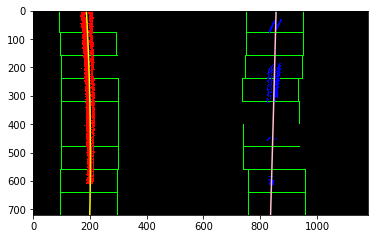

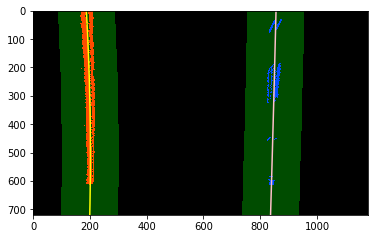

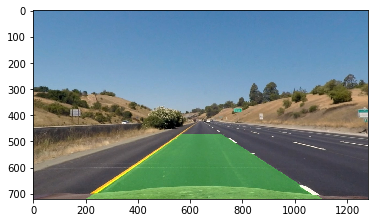

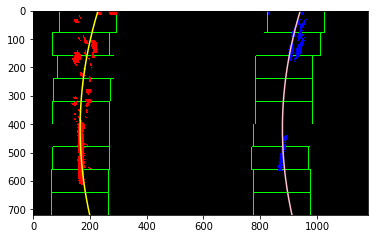

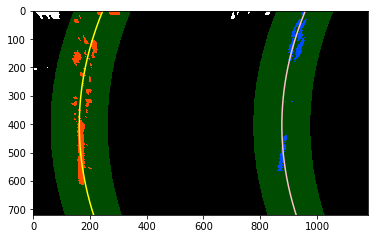

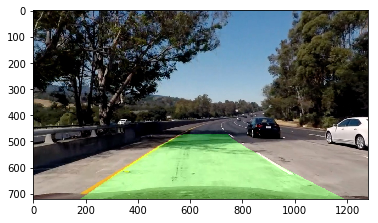

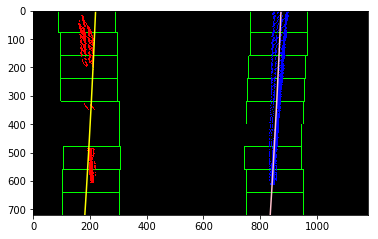

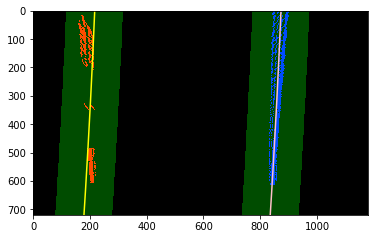

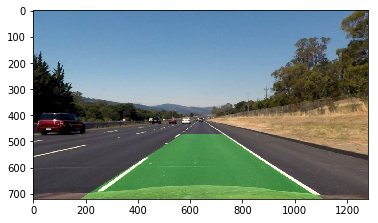

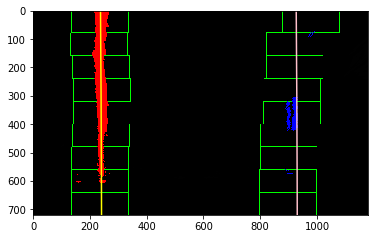

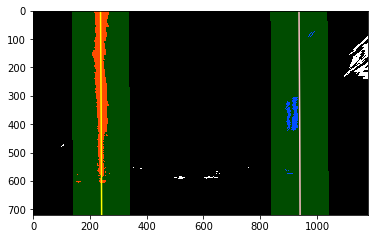

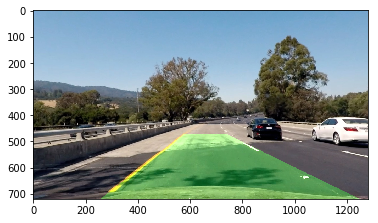

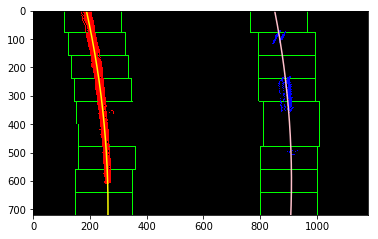

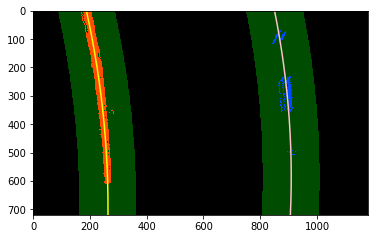

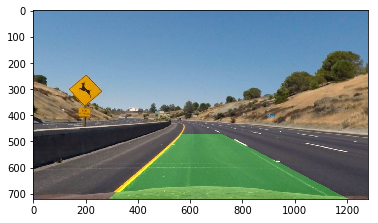

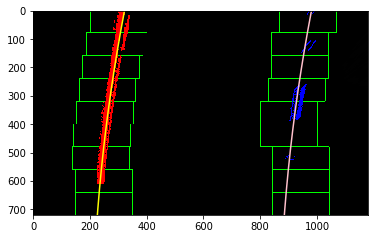

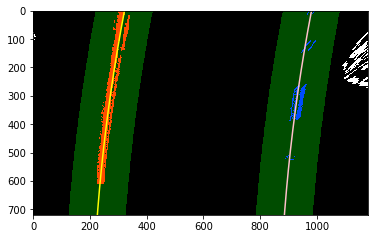

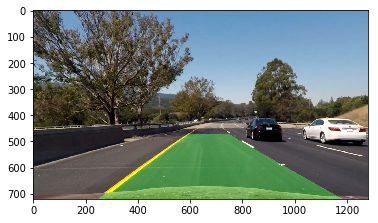

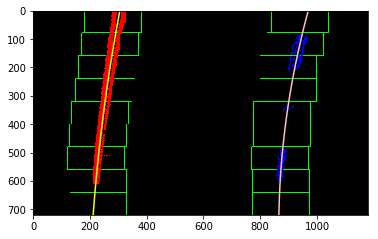

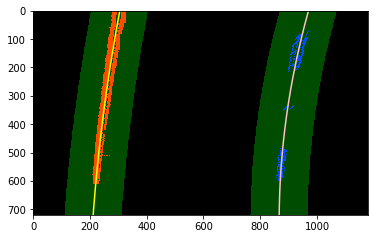

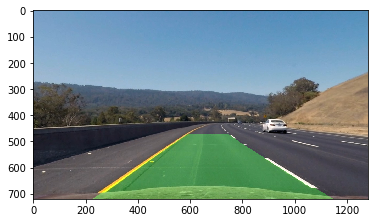

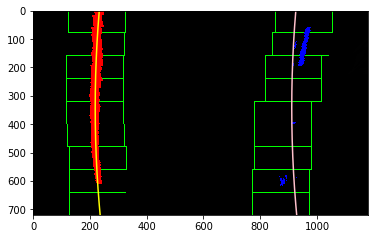

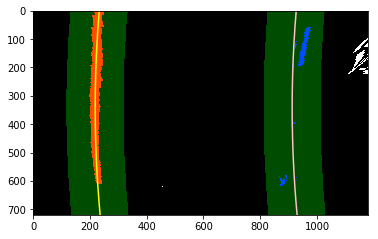

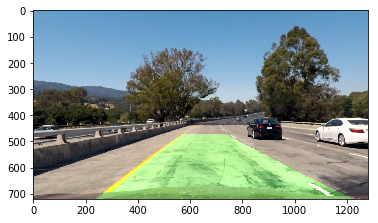

In [53]:
inp_list = os.listdir("./test_images/")

for im_name in inp_list:
    filename = "./test_images/" + im_name
    img = mpimg.imread(filename)
    img_work = np.copy(img)
    undist = undistort(img_work,cm,dcoeff)
    s_binary = s_threshold(undist, s_thres=(150,255))
    grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
    grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
    grad_binary = mag_thresh(undist, 5, (80, 180))
    dir_binary = dir_threshold(undist, 5, (0.7,1.3))

    #print(s_binary.shape, grad_binary.shape, grad_x_binary.shape, grad_y_binary.shape)

    plottable = np.zeros_like(s_binary)
    plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1
    warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    out_img, roc, left_fit, right_fit = fit_polynomial(warped[:,:-100])
    result, left_fitx, right_fitx, ploty = search_around_poly(warped[:,:-100],left_fit, right_fit)
    final = draw_on_actual(warped, undist, left_fitx, right_fitx, ploty)
    plt.imshow(out_img, cmap='gray')
    plt.figure()
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='pink')
    plt.imshow(result, cmap = 'gray')
    plt.figure()
    plt.imshow(final)
    plt.figure()

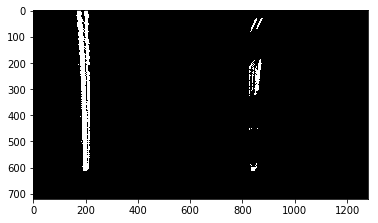

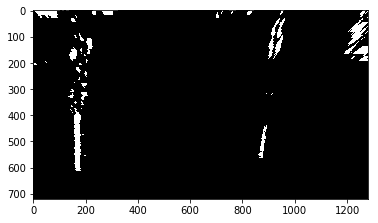

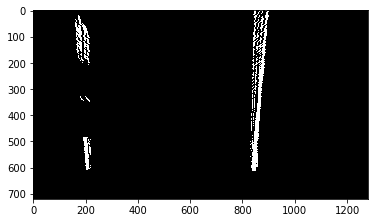

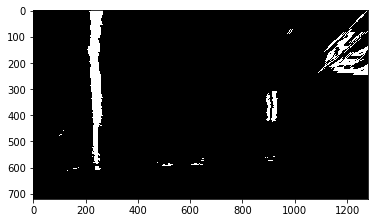

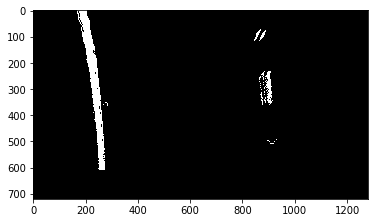

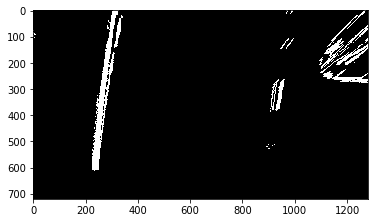

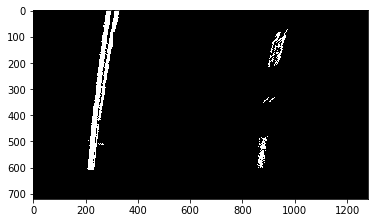

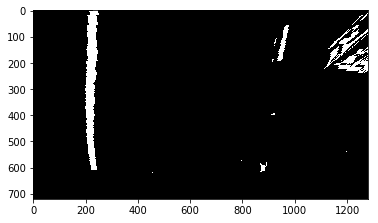

In [152]:
inp_list = os.listdir("./test_images/")

for im_name in inp_list:
    filename = "./test_images/" + im_name
    img = mpimg.imread(filename)
    img_work = np.copy(img)
    undist = undistort(img_work,cm,dcoeff)
    s_binary = s_threshold(undist, s_thres=(150,255))
    grad_x_binary = abs_sobel_thresh(undist, 'x', 5, (80,150))
    grad_y_binary = abs_sobel_thresh(undist, 'y', 5, (0,80))
    grad_binary = mag_thresh(undist, 5, (80, 180))
    dir_binary = dir_threshold(undist, 5, (0.7,1.3))

    #print(s_binary.shape, grad_binary.shape, grad_x_binary.shape, grad_y_binary.shape)

    plottable = np.zeros_like(s_binary)
    plottable[(s_binary == 1) | ((grad_x_binary == 1) & (grad_y_binary ==1)) | ((grad_binary ==1) & (dir_binary == 1))] = 1
    warped = cv2.warpPerspective(plottable, PM, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    #out_img = fit_polynomial(warped)
    plt.imshow(warped, cmap='gray')
    plt.figure()

In [178]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [179]:
line = Line()

In [234]:
left_fit

array([ -4.31531415e-05,   1.94984094e-03,   1.37109683e+00])